# Кластеризация транзакций (малая выборка: 10 000 операций)
#### (по исходным данным конкурса Sberbank Data Challenge)

## Описание данных
На входе имеем CSV файл с 6 признаками (2 из них в дальнейшем исключим из обработки), CSV файл получен в результате предварительной обработки исходных данных в MS SQL сервере.
### Исходные данные были "обогащены" дополнительными признаками - features, используя агрегатные функции PostgreSQL для облегчения кластеризации клиентов и возможного выделения клиентов возможно вовлеченных в мошеннические схемы.
###     Описание полей CSV файла:
####    1. customer_id - уникальный номер клиента
####    2. customer_id - уникальный номер клиента
####    3. amount - сумма операции
####    4. res_hour - час суток проведения операции
####    5. tr_type_str - категориальный признак - тип тразакции
####    6. mcc_code_str - категориальный признак - mcc код операции

## Imports
#### Импортируем необходимые библиотеки

In [1]:
%matplotlib inline
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
# для массштабирования признаков обучающей и тестовой выборки
from sklearn.preprocessing import StandardScaler


## Data Management
#### Загрузка данных

In [50]:
#Load the dataset
data_all = pd.read_csv('tb_transactions_fr2_10t.gz', compression='gzip')
#data_all = pd.read_csv('tb_transactions_fr2_6m.gz', compression='gzip')

data_all.head()

,id,customer_id,amount,res_hour,tr_type_str,mcc_code_str
0,1,39026145,-2245.91990,10,TRT1030,MCC4814
1,2,39026145,56147.89100,10,TRT7010,MCC6011
2,3,39026145,-56147.89100,10,TRT2330,MCC4829
3,4,39026145,-1392.47000,10,TRT1010,MCC5499
4,5,39026145,-920.83002,15,TRT1010,MCC5499


In [52]:
# исключаем из обработки эти 2 поля
X = data_all.drop(['id','customer_id'], 1)

In [53]:
X.head()

,amount,res_hour,tr_type_str,mcc_code_str
0,-2245.91990,10,TRT1030,MCC4814
1,56147.89100,10,TRT7010,MCC6011
2,-56147.89100,10,TRT2330,MCC4829
3,-1392.47000,10,TRT1010,MCC5499
4,-920.83002,15,TRT1010,MCC5499


In [54]:
X.shape

(10000, 4)

In [58]:
# разделяем обрабоку чисел и категориальных признаков
num_cols =['amount', 'res_hour']
cat_cols =['tr_type_str', 'mcc_code_str']

In [92]:
X_num = X[num_cols]
X_cat = X[cat_cols]
X_num.shape
#X_num
#X_cat.shape
#X_cat

(10000, 2)

In [75]:
# масштабируем вещественные признаки:
# normalize the data attributes
X_numN = preprocessing.normalize(X_num)

X_numN

array([[ -9.99990088e-01,   4.45247441e-03],
       [  9.99999984e-01,   1.78101077e-04],
       [ -9.99999984e-01,   1.78101077e-04],
       ..., 
       [  9.99999501e-01,   9.99444359e-04],
       [  9.99999519e-01,   9.81143804e-04],
       [  9.99996432e-01,   2.67150487e-03]])

In [76]:
# Преобразование категориальных признаков в векторы
from sklearn.feature_extraction import DictVectorizer as DV
encoder = DV(sparse = False)
X_catV = encoder.fit_transform(X_cat.T.to_dict().values())
X_catV.shape
#X_catV

(10000L, 122L)

In [77]:
clus_train=np.hstack((X_numN, X_catV))
clus_train.shape

(10000L, 124L)

### Таким образом после векторизации 2-х категориальных признаков мы получили 122 признака,  присоединяем еще к ним 2 вещественных признака, итого для кластеризации - 124 признака.

## Определение возможного количества кластеров
#### Запускаем k-means cluster analysis для 1-30 clusters

In [82]:
from scipy.spatial.distance import cdist
clusters=range(1,30)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(clus_train)
    #Adding average euclidean distance between the model.cluster_centers_, the cluster centroids from the model results, to array.
    meandist.append(sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1)) 
    / clus_train.shape[0])

## Plotting
### Для определения количества кластеров отрисовываем средние евклидовы расстояния до каждого элемента от центроида кластера, используя метод Elbow.

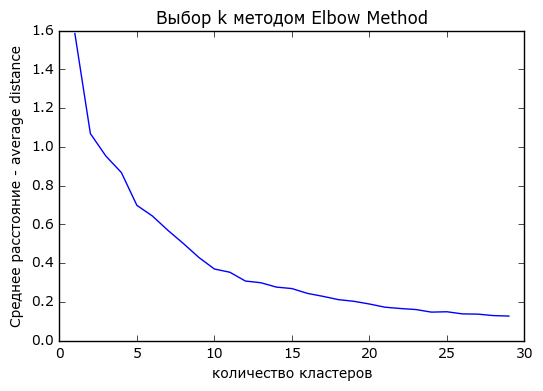

In [83]:
import matplotlib
matplotlib.rc('font', family='Verdana')

plt.plot(clusters, meandist)
plt.xlabel(u'количество кластеров')
plt.ylabel(u'Среднее расстояние - average distance')
plt.title(u'Выбор k методом Elbow Method')

### Таким образом, предположительно в данных можно выделить 10 кластеров
Далее  для кластеризации данных будем использовать алгоритм KMeans, а для визуального отображения результатов кластеризации (понижение размерности или проецирование многомерных данных кластеров на плоскость) метод TSNE.

# Interpreting the 10 Cluster Solution TSNE

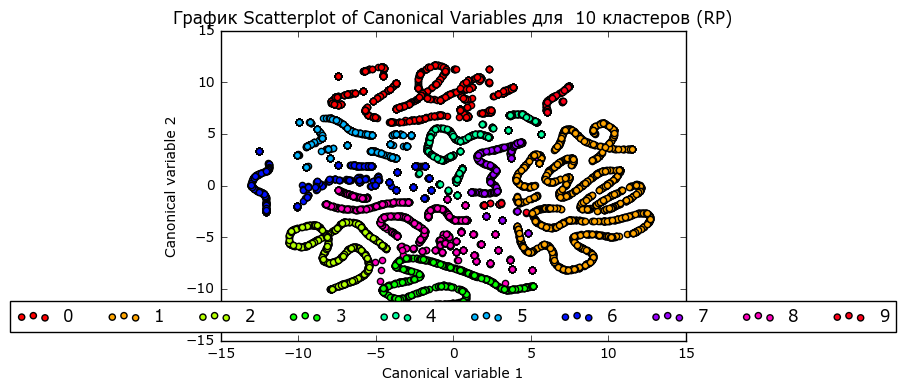

In [90]:
model10=KMeans(n_clusters=10)
model10.fit(clus_train)
# plot clusters

from sklearn import manifold
tsne = manifold.TSNE(n_components = 2, init = 'pca', random_state = 0)
plot_columns = tsne.fit_transform(clus_train)

#Merge pca results with cluster_ids for future reference
pca_clusters_tsne10 = pd.DataFrame({'x':plot_columns[:,0],'y':plot_columns[:,1],'cluster':model10.labels_[:]})

#Adding a legend with labels
#colors= ['r','g','b','y']
hsv = plt.get_cmap('hsv')
colors = hsv(np.linspace(0, 1.0, 10))


#Create empty array of objects to receive plots
c = [None] * 10

for i in range(0, plot_columns.shape[0]):
    c[model10.labels_[i]] =  plt.scatter(x=plot_columns[i,0], y=plot_columns[i,1], c=colors[model10.labels_[i]],label=model10.labels_[i])

import matplotlib
matplotlib.rc('font', family='Verdana')
    
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.legend(c, ['0','1','2','3','4','5','6','7','8','9'],loc='lower center', ncol=10)
plt.title(u'График Scatterplot of Canonical Variables для  10 кластеров (TSNE)')
plt.show()

In [91]:
# cluster frequencies
pca_clusters_tsne10.cluster.value_counts()

1    2254
8    1382
0    1321
6    1127
4     830
3     793
2     759
5     693
7     583
9     258
Name: cluster, dtype: int64

### Исходя из проведенного кластерного анализа следует обратить внимание и более внимательно изучить признаки операций отнесенных в одни и те же кластеры, особенно кластеры с небольшим количеством операций, где вероятность мошенничества более высока.